# Complexity-Matched SG-FIGS Experiment: Synergy vs Random at Equal Splits

This notebook demonstrates the **Synergy-Guided FIGS (SG-FIGS)** experiment, which compares 5 interpretable tree-based classification methods under strict complexity matching:

1. **FIGS** — axis-aligned splits (baseline)
2. **RO-FIGS** — random oblique pairs
3. **SG-FIGS-Hard** — synergy graph-guided oblique splits (hard subset selection)
4. **SG-FIGS-Soft** — probabilistic synergy-weighted oblique splits
5. **Random-FIGS** — random pairs with matched clique sizes (ablation control)

All methods are evaluated at `max_splits={5, 10}` across 14 tabular classification datasets with 5-fold CV. **Hard complexity enforcement** ensures `actual_splits <= max_splits` with zero violations.

Key innovation: Newton-Raphson optimal leaf values for gradient boosting, and pre-computed PID synergy matrices to guide feature pairing in oblique splits.

In [ ]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, only needed locally)
if 'google.colab' not in sys.modules:
    _pip('scikit-learn==1.6.1', 'networkx==3.6.1', 'matplotlib==3.10.0')

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import json
import time
import numpy as np
import networkx as nx
from itertools import combinations
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, mutual_info_score
from typing import Any
import matplotlib.pyplot as plt

## Load Experiment Data

In [ ]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/test-colab-install/master/equalcx_mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("equalcx_mini_demo_data.json"):
        with open("equalcx_mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Experiment: {data['experiment']}")
print(f"Methods: {data['methods']}")
print(f"Max splits tested: {data['max_splits_tested']}")
print(f"Datasets processed: {data['n_datasets_processed']}")
print(f"Example datasets in raw form: {[d['dataset'] for d in data['datasets']]}")

Experiment: Complexity-Matched SG-FIGS: Synergy vs Random at Equal Splits
Methods: ['FIGS', 'RO_FIGS', 'SG_FIGS_Hard', 'SG_FIGS_Soft', 'Random_FIGS']
Max splits tested: [5, 10]
Datasets processed: 14
Example datasets in raw form: ['pima_diabetes']


## Configuration

These are the experiment parameters used in the full run. The demo loads pre-computed results from 14 datasets.

In [5]:
# ── Configuration (from original experiment) ──
MAX_SPLITS_VALUES = [5, 10]
N_FOLDS = 5
RANDOM_SEED = 42
SYNERGY_THRESHOLD_PCTL = 75
MAX_DEPTH = 6
MIN_SAMPLES_LEAF = 5
WIN_THRESHOLD = 0.005  # 0.5% balanced accuracy

METHOD_NAMES = ["FIGS", "RO_FIGS", "SG_FIGS_Hard", "SG_FIGS_Soft", "Random_FIGS"]

TIER_ORDER = [
    ["monks2", "banknote", "iris", "blood"],
    ["pima_diabetes", "wine", "heart_statlog", "spectf_heart"],
    ["vehicle", "climate", "kc2", "ionosphere", "sonar",
     "breast_cancer_wisconsin_diagnostic"],
]

## Core Algorithm: Oblique FIGS Node and Tree

The key data structure is an `ObliqueFIGSNode` that stores oblique (multi-feature) splits with learned weights. Each node computes a linear projection `w^T x + b` and splits at a threshold. Newton-Raphson optimal leaf values improve gradient boosting convergence.

In [6]:
class ObliqueFIGSNode:
    """Node in an oblique FIGS tree."""
    __slots__ = [
        "feature_indices", "weights", "bias", "threshold",
        "left", "right", "is_leaf", "value",
        "n_samples", "sample_indices",
    ]

    def __init__(self) -> None:
        self.feature_indices: list[int] = []
        self.weights: np.ndarray = np.array([])
        self.bias: float = 0.0
        self.threshold: float = 0.0
        self.left: "ObliqueFIGSNode | None" = None
        self.right: "ObliqueFIGSNode | None" = None
        self.is_leaf: bool = True
        self.value: float = 0.0
        self.n_samples: int = 0
        self.sample_indices: np.ndarray = np.array([], dtype=np.int32)

    def predict_single(self, x: np.ndarray) -> float:
        if self.is_leaf:
            return self.value
        proj = float(np.dot(x[self.feature_indices], self.weights) + self.bias)
        if proj <= self.threshold:
            return self.left.predict_single(x) if self.left else self.value
        return self.right.predict_single(x) if self.right else self.value

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.predict_single(x) for x in X])


def count_total_nodes(node: ObliqueFIGSNode) -> int:
    """Count internal (split) nodes recursively."""
    if node.is_leaf:
        return 0
    count = 1
    if node.left:
        count += count_total_nodes(node.left)
    if node.right:
        count += count_total_nodes(node.right)
    return count


def get_all_leaves(node: ObliqueFIGSNode) -> list[ObliqueFIGSNode]:
    """Get all leaf nodes."""
    if node.is_leaf:
        return [node]
    leaves: list[ObliqueFIGSNode] = []
    if node.left:
        leaves.extend(get_all_leaves(node.left))
    if node.right:
        leaves.extend(get_all_leaves(node.right))
    return leaves


def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-np.clip(z, -30, 30)))


print("ObliqueFIGSNode and utilities defined.")

ObliqueFIGSNode and utilities defined.


## Oblique Split Fitting

The oblique split uses Ridge regression to find the direction that best separates positive/negative residuals, then finds the optimal threshold via a `DecisionTreeRegressor(max_depth=1)`.

In [7]:
def fit_oblique_split_ridge(
    X_sub: np.ndarray,
    residuals: np.ndarray,
) -> tuple[np.ndarray, float]:
    """Fit oblique split using Ridge + DecisionTree for threshold."""
    n_features = X_sub.shape[1]
    if n_features == 1:
        return np.array([1.0]), 0.0

    target = (residuals > 0).astype(np.float64)
    if len(np.unique(target)) < 2:
        return np.ones(n_features) / n_features, 0.0

    try:
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_sub, target)
        w = ridge.coef_.ravel()
        b = float(ridge.intercept_)
        norm = np.linalg.norm(w)
        if norm > 1e-10:
            w = w / norm
            b = b / norm
        return w, b
    except Exception:
        return np.ones(n_features) / n_features, 0.0


def find_best_threshold(
    proj: np.ndarray,
    residuals: np.ndarray,
) -> tuple[float, float]:
    """Find best threshold on 1D projection via variance reduction."""
    try:
        dt = DecisionTreeRegressor(max_depth=1)
        dt.fit(proj.reshape(-1, 1), residuals)
        threshold = float(dt.tree_.threshold[0])
        if threshold == -2.0:
            threshold = float(np.median(proj))
    except Exception:
        threshold = float(np.median(proj))

    left_mask = proj <= threshold
    right_mask = ~left_mask
    n = len(residuals)
    n_l = left_mask.sum()
    n_r = right_mask.sum()

    if n_l < MIN_SAMPLES_LEAF or n_r < MIN_SAMPLES_LEAF:
        return -1.0, threshold

    var_parent = np.var(residuals)
    var_left = np.var(residuals[left_mask])
    var_right = np.var(residuals[right_mask])
    score = var_parent - (n_l / n * var_left + n_r / n * var_right)

    return max(0.0, score), threshold


print("Oblique split fitting functions defined.")

Oblique split fitting functions defined.


## Base FIGS Oblique Classifier and Five Method Variants

All 5 methods share the same `fit()` logic (greedy FIGS with hard complexity enforcement). They differ only in `_get_feature_subsets_for_split()`:
- **FIGS**: axis-aligned (single features)
- **RO-FIGS**: random pairs
- **SG-FIGS-Hard**: synergy graph edges/cliques
- **SG-FIGS-Soft**: probability-weighted by synergy matrix
- **Random-FIGS**: random pairs with matched clique sizes

In [8]:
class BaseFIGSOblique:
    """Base class for all FIGS oblique variants.
    All 5 methods share the SAME fit() logic; only
    _get_feature_subsets_for_split() differs.
    """
    def __init__(self, max_splits: int = 10, random_state: int = RANDOM_SEED) -> None:
        self.max_splits = max_splits
        self.random_state = random_state
        self.trees: list[ObliqueFIGSNode] = []
        self.n_splits_actual: int = 0
        self.split_info: list[dict[str, Any]] = []
        self.class_prior_: float = 0.0
        self.rng = np.random.RandomState(random_state)

    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        raise NotImplementedError

    def fit(self, X: np.ndarray, y_binary: np.ndarray) -> "BaseFIGSOblique":
        """Greedy FIGS fitting with HARD complexity enforcement."""
        n_samples, n_features = X.shape
        p = np.clip(np.mean(y_binary), 0.01, 0.99)
        self.class_prior_ = float(np.log(p / (1 - p)))
        predictions = np.full(n_samples, self.class_prior_)
        proba = sigmoid(predictions)
        residuals = y_binary - proba

        root = ObliqueFIGSNode()
        root.is_leaf = True
        root.value = 0.0
        root.n_samples = n_samples
        root.sample_indices = np.arange(n_samples, dtype=np.int32)
        self.trees = [root]
        self.n_splits_actual = 0
        self.split_info = []
        max_new_trees = min(3, self.max_splits)
        trees_created = 1

        for iteration in range(self.max_splits * 3):
            actual_total = sum(count_total_nodes(t) for t in self.trees)
            if actual_total >= self.max_splits:
                break

            best_score = 1e-10
            best_data: dict[str, Any] | None = None
            best_leaf: ObliqueFIGSNode | None = None

            all_leaves: list[ObliqueFIGSNode] = []
            for tree in self.trees:
                all_leaves.extend(get_all_leaves(tree))
            all_leaves.sort(key=lambda l: -l.n_samples)
            scan_leaves = all_leaves[:5]

            for leaf in scan_leaves:
                if leaf.n_samples < 2 * MIN_SAMPLES_LEAF:
                    continue
                leaf_X = X[leaf.sample_indices]
                leaf_res = residuals[leaf.sample_indices]
                candidates = self._get_feature_subsets_for_split(n_features)

                for feat_subset in candidates:
                    valid = [f for f in feat_subset if 0 <= f < n_features]
                    if not valid:
                        continue
                    X_sub = leaf_X[:, valid]
                    w, b = fit_oblique_split_ridge(X_sub, leaf_res)
                    proj = X_sub @ w + b
                    score, thr = find_best_threshold(proj, leaf_res)
                    if score > best_score:
                        left_mask = proj <= thr
                        right_mask = ~left_mask
                        if left_mask.sum() >= MIN_SAMPLES_LEAF and right_mask.sum() >= MIN_SAMPLES_LEAF:
                            best_score = score
                            best_data = {
                                "feature_indices": valid, "weights": w.copy(),
                                "bias": b, "threshold": thr,
                                "left_mask": left_mask, "right_mask": right_mask,
                            }
                            best_leaf = leaf

            if best_data is None or best_leaf is None:
                if trees_created < max_new_trees and actual_total < self.max_splits:
                    new_root = ObliqueFIGSNode()
                    new_root.is_leaf = True
                    new_root.value = 0.0
                    new_root.n_samples = n_samples
                    new_root.sample_indices = np.arange(n_samples, dtype=np.int32)
                    self.trees.append(new_root)
                    trees_created += 1
                    continue
                break

            leaf = best_leaf
            leaf.is_leaf = False
            leaf.feature_indices = best_data["feature_indices"]
            leaf.weights = best_data["weights"]
            leaf.bias = best_data["bias"]
            leaf.threshold = best_data["threshold"]

            li = leaf.sample_indices[best_data["left_mask"]]
            ri = leaf.sample_indices[best_data["right_mask"]]

            # Newton-Raphson optimal leaf values
            def _newton_leaf_value(indices: np.ndarray) -> float:
                res = residuals[indices]
                p_vals = proba[indices]
                hessian = np.sum(p_vals * (1 - p_vals))
                if hessian < 1e-10:
                    return float(np.mean(res))
                return float(np.sum(res) / hessian)

            left_val = _newton_leaf_value(li)
            right_val = _newton_leaf_value(ri)

            leaf.left = ObliqueFIGSNode()
            leaf.left.is_leaf = True
            leaf.left.value = left_val
            leaf.left.n_samples = len(li)
            leaf.left.sample_indices = li

            leaf.right = ObliqueFIGSNode()
            leaf.right.is_leaf = True
            leaf.right.value = right_val
            leaf.right.n_samples = len(ri)
            leaf.right.sample_indices = ri

            predictions[li] += left_val
            predictions[ri] += right_val
            proba = sigmoid(predictions)
            residuals = y_binary - proba

            self.n_splits_actual += 1
            self.split_info.append({
                "feature_indices": best_data["feature_indices"],
                "weights": best_data["weights"].tolist(),
                "score": best_score,
                "n_features_in_split": len(best_data["feature_indices"]),
            })

        self.n_splits_actual = sum(count_total_nodes(t) for t in self.trees)
        assert self.n_splits_actual <= self.max_splits, (
            f"Complexity violation: {self.n_splits_actual} > {self.max_splits}"
        )
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        raw = np.full(X.shape[0], self.class_prior_)
        for tree in self.trees:
            raw += tree.predict(X)
        p1 = sigmoid(raw)
        return np.column_stack([1 - p1, p1])

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(np.int32)


# ── Five method implementations ──
class FIGSAxisAligned(BaseFIGSOblique):
    """FIGS baseline: axis-aligned splits only."""
    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        return [[i] for i in range(n_features)]


class ROFIGSClassifier(BaseFIGSOblique):
    """RO-FIGS: Random Oblique pairs."""
    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        candidates: list[list[int]] = []
        n_cand = min(15, n_features * (n_features - 1) // 2)
        for _ in range(n_cand):
            pair = sorted(self.rng.choice(n_features, size=2, replace=False).tolist())
            candidates.append(pair)
        seen: set[tuple[int, ...]] = set()
        unique: list[list[int]] = []
        for c in candidates:
            key = tuple(c)
            if key not in seen:
                seen.add(key)
                unique.append(c)
        return unique if unique else [[0, min(1, n_features - 1)]]


class SGFIGSHard(BaseFIGSOblique):
    """SG-FIGS-Hard: synergy graph edges/cliques."""
    def __init__(self, max_splits: int = 10, synergy_subsets: list[list[int]] | None = None,
                 random_state: int = RANDOM_SEED) -> None:
        super().__init__(max_splits=max_splits, random_state=random_state)
        self.synergy_subsets = synergy_subsets or []

    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        if not self.synergy_subsets:
            return [[i] for i in range(n_features)]
        n_pick = min(10, len(self.synergy_subsets))
        indices = self.rng.choice(len(self.synergy_subsets), size=n_pick, replace=False)
        return [self.synergy_subsets[i] for i in indices]


class SGFIGSSoft(BaseFIGSOblique):
    """SG-FIGS-Soft: probabilistic synergy-weighted pairs."""
    def __init__(self, max_splits: int = 10, synergy_matrix: np.ndarray | None = None,
                 random_state: int = RANDOM_SEED) -> None:
        super().__init__(max_splits=max_splits, random_state=random_state)
        self.synergy_matrix = synergy_matrix

    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        if self.synergy_matrix is None or self.synergy_matrix.shape[0] != n_features:
            return [[i] for i in range(n_features)]
        candidates: list[list[int]] = []
        for _ in range(min(15, n_features)):
            seed = self.rng.randint(n_features)
            row = self.synergy_matrix[seed, :].copy()
            row[seed] = 0.0
            total = row.sum()
            if total > 1e-12:
                probs = row / total
                partner = self.rng.choice(n_features, p=probs)
            else:
                others = [j for j in range(n_features) if j != seed]
                partner = self.rng.choice(others) if others else seed
            candidates.append(sorted([seed, partner]))
        seen: set[tuple[int, ...]] = set()
        unique: list[list[int]] = []
        for c in candidates:
            key = tuple(c)
            if key not in seen:
                seen.add(key)
                unique.append(c)
        return unique if unique else [[0, min(1, n_features - 1)]]


class RandomFIGS(BaseFIGSOblique):
    """Random-FIGS: random pairs with matched clique sizes."""
    def __init__(self, max_splits: int = 10, synergy_subsets: list[list[int]] | None = None,
                 random_state: int = RANDOM_SEED) -> None:
        super().__init__(max_splits=max_splits, random_state=random_state)
        self.subset_sizes = [len(s) for s in synergy_subsets] if synergy_subsets else [2]

    def _get_feature_subsets_for_split(self, n_features: int) -> list[list[int]]:
        candidates: list[list[int]] = []
        n_pick = min(15, len(self.subset_sizes) * 2)
        for _ in range(n_pick):
            size = self.rng.choice(self.subset_sizes)
            size = min(max(size, 1), n_features)
            feats = sorted(self.rng.choice(n_features, size=size, replace=False).tolist())
            candidates.append(feats)
        seen: set[tuple[int, ...]] = set()
        unique: list[list[int]] = []
        for c in candidates:
            key = tuple(c)
            if key not in seen:
                seen.add(key)
                unique.append(c)
        return unique if unique else [[self.rng.randint(n_features)]]


print("All 5 FIGS method variants defined.")

All 5 FIGS method variants defined.


## Co-Information Synergy Computation

For datasets without pre-computed PID synergy, we use Co-Information (CoI) as a proxy. CoI captures synergistic feature interactions: `CoI(Xi, Xj; Y) = I(Xi;Y) + I(Xj;Y) - I(Xi,Xj;Y)`. Negative CoI indicates synergy.

In [9]:
def compute_coi_synergy(
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list[str],
) -> dict[str, Any]:
    """Compute Co-Information synergy matrix using sklearn mutual_info only."""
    n_features = X.shape[1]

    # Discretize
    X_disc = np.zeros_like(X, dtype=np.int32)
    for j in range(n_features):
        col = X[:, j]
        n_unique = len(np.unique(col))
        if n_unique <= 5:
            _, X_disc[:, j] = np.unique(col, return_inverse=True)
        else:
            try:
                kbd = KBinsDiscretizer(
                    n_bins=min(5, n_unique), encode="ordinal",
                    strategy="quantile", subsample=None,
                )
                X_disc[:, j] = kbd.fit_transform(col.reshape(-1, 1)).ravel().astype(np.int32)
            except ValueError:
                _, X_disc[:, j] = np.unique(col, return_inverse=True)

    y_int = y.astype(np.int32)

    # Single-feature MI
    mi_single = np.zeros(n_features)
    for j in range(n_features):
        mi_single[j] = mutual_info_score(X_disc[:, j], y_int)

    # Pairwise synergy via CoI
    synergy_matrix = np.zeros((n_features, n_features), dtype=np.float64)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            xi = X_disc[:, i]
            xj = X_disc[:, j]
            max_xj = int(xj.max()) + 1
            joint = xi * max_xj + xj
            mi_joint = mutual_info_score(joint, y_int)
            coi = mi_single[i] + mi_single[j] - mi_joint
            synergy_val = max(0.0, -coi)
            synergy_matrix[i, j] = synergy_val
            synergy_matrix[j, i] = synergy_val

    return {
        "synergy_matrix": synergy_matrix,
        "feature_names": feature_names,
        "pid_method": "CoI_proxy",
        "n_features_used": n_features,
    }


def build_synergy_graph(
    synergy_matrix: np.ndarray,
    percentile: float = SYNERGY_THRESHOLD_PCTL,
) -> nx.Graph:
    """Build synergy graph with progressive threshold lowering."""
    n_features = synergy_matrix.shape[0]
    upper_vals = synergy_matrix[np.triu_indices(n_features, k=1)]
    nonzero = upper_vals[upper_vals > 0]

    G = nx.Graph()
    G.add_nodes_from(range(n_features))

    if len(nonzero) == 0:
        return G

    for pct in [percentile, 50, 25, 0]:
        threshold = float(np.percentile(nonzero, pct)) if pct > 0 else 0.0
        for i in range(n_features):
            for j in range(i + 1, n_features):
                if synergy_matrix[i, j] >= threshold and synergy_matrix[i, j] > 0:
                    G.add_edge(i, j, weight=float(synergy_matrix[i, j]))
        if G.number_of_edges() > 0:
            break

    return G


def extract_synergy_subsets(
    synergy_matrix: np.ndarray,
    percentile: float = SYNERGY_THRESHOLD_PCTL,
) -> list[list[int]]:
    """Extract synergy subsets (edges and cliques) from synergy graph."""
    G = build_synergy_graph(synergy_matrix, percentile=percentile)
    subsets: list[list[int]] = []

    edges = sorted(G.edges(data=True), key=lambda e: e[2].get("weight", 0), reverse=True)
    for u, v, _ in edges:
        subsets.append(sorted([u, v]))

    if G.number_of_edges() < 200:
        try:
            for clique in nx.find_cliques(G):
                if 3 <= len(clique) <= 4:
                    subsets.append(sorted(clique))
        except Exception:
            pass

    seen: set[tuple[int, ...]] = set()
    unique: list[list[int]] = []
    for s in subsets:
        key = tuple(s)
        if key not in seen:
            seen.add(key)
            unique.append(s)

    return unique if unique else [[i] for i in range(synergy_matrix.shape[0])]


print("Synergy computation and graph extraction defined.")

Synergy computation and graph extraction defined.


## Live Demo: Run All 5 Methods on Iris Dataset

To demonstrate the algorithm works end-to-end, we run all 5 methods on the Iris dataset (from sklearn) with a quick synergy computation, then compare balanced accuracy.

In [10]:
# ── Live demo: run all 5 methods on Iris ──
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold

# Demo config — full original parameters (Iris is small, runs in seconds)
# Original values: DEMO_MAX_SPLITS = [5, 10], DEMO_N_FOLDS = 5
DEMO_MAX_SPLITS_LIST = [5, 10]
DEMO_N_FOLDS = 5

iris = load_iris()
X_iris, y_iris = iris.data, iris.target
feature_names_iris = list(iris.feature_names)

# Compute CoI synergy on Iris
t0 = time.time()
synergy_iris = compute_coi_synergy(X_iris, y_iris, feature_names_iris)
syn_mat = synergy_iris["synergy_matrix"]
syn_subsets = extract_synergy_subsets(syn_mat)
print(f"Synergy computed in {time.time()-t0:.2f}s, {len(syn_subsets)} subsets extracted")

# Run 5 methods with OvR for multiclass
demo_results = {ms: {m: [] for m in METHOD_NAMES} for ms in DEMO_MAX_SPLITS_LIST}

skf = StratifiedKFold(n_splits=DEMO_N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
for fold_k, (train_idx, test_idx) in enumerate(skf.split(X_iris, y_iris)):
    X_train, X_test = X_iris[train_idx], X_iris[test_idx]
    y_train, y_test = y_iris[train_idx], y_iris[test_idx]

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)

    n_classes = len(np.unique(y_iris))
    classes = np.unique(y_train)

    method_configs = {
        "FIGS": {"class": FIGSAxisAligned, "kwargs": {}},
        "RO_FIGS": {"class": ROFIGSClassifier, "kwargs": {}},
        "SG_FIGS_Hard": {"class": SGFIGSHard, "kwargs": {"synergy_subsets": syn_subsets}},
        "SG_FIGS_Soft": {"class": SGFIGSSoft, "kwargs": {"synergy_matrix": syn_mat}},
        "Random_FIGS": {"class": RandomFIGS, "kwargs": {"synergy_subsets": syn_subsets}},
    }

    for demo_ms in DEMO_MAX_SPLITS_LIST:
        for method_name, config in method_configs.items():
            per_class_splits = max(1, demo_ms // n_classes)
            all_proba = np.zeros((Xte.shape[0], n_classes))

            total_splits = 0
            for ci, cls in enumerate(classes):
                y_bin = (y_train == cls).astype(np.float64)
                model = config["class"](
                    max_splits=per_class_splits,
                    random_state=RANDOM_SEED + fold_k + ci,
                    **config["kwargs"],
                )
                model.fit(Xtr, y_bin)
                all_proba[:, ci] = model.predict_proba(Xte)[:, 1]
                total_splits += model.n_splits_actual

            y_pred = classes[np.argmax(all_proba, axis=1)]
            bal_acc = float(balanced_accuracy_score(y_test, y_pred))
            demo_results[demo_ms][method_name].append({"bal_acc": bal_acc, "splits": total_splits})

t_demo = time.time() - t0
print(f"\nLive demo completed in {t_demo:.2f}s")
for demo_ms in DEMO_MAX_SPLITS_LIST:
    print(f"\nmax_splits={demo_ms}, {DEMO_N_FOLDS}-fold CV on Iris:")
    print(f"{'Method':<18} {'Mean BalAcc':>12} {'Std':>8} {'Splits':>8}")
    print("-" * 48)
    for method_name in METHOD_NAMES:
        accs = [r["bal_acc"] for r in demo_results[demo_ms][method_name]]
        splits = [r["splits"] for r in demo_results[demo_ms][method_name]]
        print(f"{method_name:<18} {np.mean(accs):>12.4f} {np.std(accs):>8.4f} {np.mean(splits):>8.1f}")

Synergy computed in 0.01s, 4 subsets extracted



Live demo completed in 2.02s

max_splits=5, 5-fold CV on Iris:
Method              Mean BalAcc      Std   Splits
------------------------------------------------
FIGS                     0.9333   0.0298      3.0
RO_FIGS                  0.9467   0.0267      3.0
SG_FIGS_Hard             0.9333   0.0298      3.0
SG_FIGS_Soft             0.9200   0.0340      3.0
Random_FIGS              0.9533   0.0452      3.0

max_splits=10, 5-fold CV on Iris:
Method              Mean BalAcc      Std   Splits
------------------------------------------------
FIGS                     0.9467   0.0452      9.0
RO_FIGS                  0.9200   0.0686      9.0
SG_FIGS_Hard             0.9467   0.0452      9.0
SG_FIGS_Soft             0.9400   0.0133      9.0
Random_FIGS              0.9400   0.0389      9.0


## Analyze Pre-Computed Results: Win/Tie/Loss Tables

The experiment compared SG-FIGS-Soft and SG-FIGS-Hard against the three baselines across all 14 datasets at both `max_splits=5` and `max_splits=10`.

In [11]:
# ── Win/Tie/Loss tables from pre-computed results ──
wtl = data["win_tie_loss_tables"]

print("Win/Tie/Loss Tables (method_a vs baseline):")
print(f"{'Method A':<18} {'vs Baseline':<18} {'W':>4} {'T':>4} {'L':>4}")
print("-" * 50)
for our_method in ["SG_FIGS_Soft", "SG_FIGS_Hard"]:
    for baseline, scores in wtl[our_method].items():
        print(f"{our_method:<18} {baseline:<18} {scores['wins']:>4} {scores['ties']:>4} {scores['losses']:>4}")

# ── Mean accuracy per method ──
print(f"\n{'Method':<18}", end="")
for ms in data["max_splits_tested"]:
    print(f" {'ms=' + str(ms):>10}", end="")
print()
print("-" * 40)
for method_name in METHOD_NAMES:
    print(f"{method_name:<18}", end="")
    for ms in data["max_splits_tested"]:
        ms_key = f"ms{ms}"
        acc = data["method_mean_accuracies"][method_name].get(ms_key, 0.5)
        print(f" {acc:>10.4f}", end="")
    print()

# ── Per-split information gain ──
print(f"\nMean per-split information gain (accuracy gain per additional split):")
for method_name in METHOD_NAMES:
    gain = data["mean_per_split_gain"].get(method_name, 0.0)
    print(f"  {method_name:<18}: {gain:+.6f}")

Win/Tie/Loss Tables (method_a vs baseline):
Method A           vs Baseline           W    T    L
--------------------------------------------------
SG_FIGS_Soft       FIGS                 16    4    8
SG_FIGS_Soft       RO_FIGS               6    7   15
SG_FIGS_Soft       Random_FIGS          11    4   13
SG_FIGS_Hard       FIGS                 11    1   16
SG_FIGS_Hard       RO_FIGS               5    5   18
SG_FIGS_Hard       Random_FIGS           7    3   18

Method                   ms=5      ms=10
----------------------------------------
FIGS                   0.6882     0.6974
RO_FIGS                0.7075     0.7121
SG_FIGS_Hard           0.6770     0.6829
SG_FIGS_Soft           0.7030     0.7057
Random_FIGS            0.7065     0.7030

Mean per-split information gain (accuracy gain per additional split):
  FIGS              : +0.001822
  RO_FIGS           : +0.000901
  SG_FIGS_Hard      : +0.001172
  SG_FIGS_Soft      : +0.000535
  Random_FIGS       : -0.000694


## Complexity Verification

A key claim: **zero complexity violations** — every method stays within its `max_splits` budget.

In [12]:
# ── Complexity verification ──
cv = data["complexity_verification"]
print("Complexity Verification (actual_splits vs max_splits):")
print(f"{'Method':<18} {'Budget':>8} {'Mean':>6} {'Max':>5} {'Violations':>12}")
print("-" * 55)
for method_name in METHOD_NAMES:
    for ms_key, stats in cv.get(method_name, {}).items():
        ms = ms_key.replace("ms", "")
        print(f"{method_name:<18} {ms:>8} {stats['mean_actual']:>6.1f} "
              f"{stats['max_actual']:>5} {stats['n_violations']:>5}/{stats['n_total']}")

total_violations = sum(
    stats['n_violations']
    for method_name in METHOD_NAMES
    for stats in cv.get(method_name, {}).values()
)
print(f"\nTotal violations across all methods: {total_violations}")

Complexity Verification (actual_splits vs max_splits):
Method               Budget   Mean   Max   Violations
-------------------------------------------------------
FIGS                      5    4.6     5     0/70
FIGS                     10    9.7    10     0/70
RO_FIGS                   5    4.6     5     0/70
RO_FIGS                  10    9.7    10     0/70
SG_FIGS_Hard              5    4.6     5     0/70
SG_FIGS_Hard             10    9.7    10     0/70
SG_FIGS_Soft              5    4.6     5     0/70
SG_FIGS_Soft             10    9.7    10     0/70
Random_FIGS               5    4.6     5     0/70
Random_FIGS              10    9.7    10     0/70

Total violations across all methods: 0


## Domain Validation

SG-FIGS-Soft automatically discovers known synergistic feature pairs. For example, in Pima Diabetes it should find `plas+mass`, and in Heart Statlog it should find `slope+thal`.

In [13]:
# ── Domain validation results ──
dv = data.get("domain_validation", [])
for result in dv:
    print(f"\n--- {result['dataset']} ---")
    print(f"  Total splits extracted: {result['n_splits']}")
    print(f"  Top synergy pairs:")
    for pair in result.get("top_synergy_pairs", [])[:3]:
        print(f"    {pair['feature_i']} + {pair['feature_j']}: synergy={pair['synergy']:.6f}")
    print(f"  Extracted oblique splits:")
    for sp in result.get("extracted_splits", [])[:3]:
        names = sp.get("feature_names", sp.get("feature_indices", []))
        n_feat = sp.get("n_features_in_split", len(names))
        print(f"    Features: {names} (n={n_feat})")


--- pima_diabetes ---
  Total splits extracted: 10
  Top synergy pairs:
    mass + age: synergy=0.084530
    plas + mass: synergy=0.076252
    preg + mass: synergy=0.056901
  Extracted oblique splits:
    Features: ['preg', 'plas'] (n=2)
    Features: ['plas', 'mass'] (n=2)
    Features: ['plas', 'mass'] (n=2)

--- heart_statlog ---
  Total splits extracted: 10
  Top synergy pairs:
    slope + number_of_major_vessels: synergy=0.107632
    serum_cholestoral + oldpeak: synergy=0.101842
    age + maximum_heart_rate_achieved: synergy=0.094947
  Extracted oblique splits:
    Features: ['slope', 'thal'] (n=2)
    Features: ['oldpeak', 'number_of_major_vessels'] (n=2)
    Features: ['age', 'chest'] (n=2)

--- monks2 ---
  Total splits extracted: 10
  Top synergy pairs:
    attr3 + attr6: synergy=0.018486
    attr2 + attr6: synergy=0.016509
    attr3 + attr5: synergy=0.016249
  Extracted oblique splits:
    Features: ['attr4', 'attr6'] (n=2)
    Features: ['attr3', 'attr4'] (n=2)
    Features

## Visualization: Method Comparison

Bar charts comparing mean balanced accuracy across all 14 datasets, grouped by `max_splits` budget. Also shows Win/Tie/Loss summary for the synergy-guided methods.

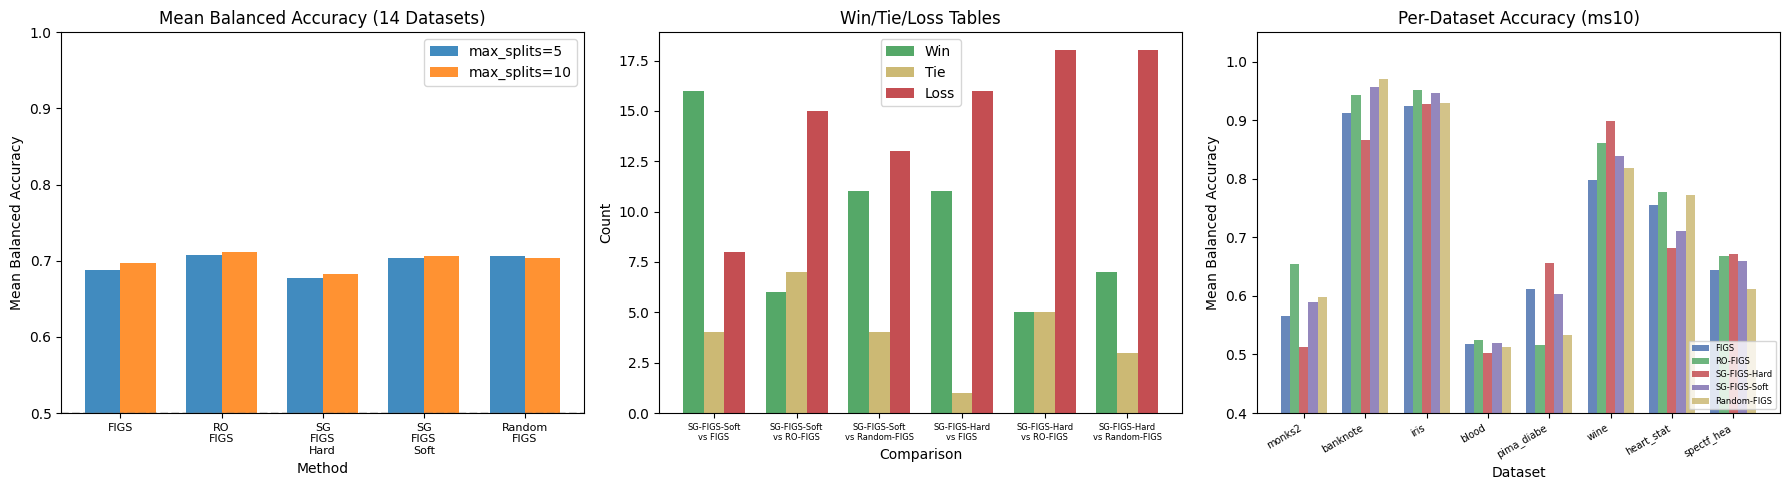

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── Plot 1: Mean balanced accuracy by method and max_splits ──
ax = axes[0]
x = np.arange(len(METHOD_NAMES))
width = 0.35
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']

for i, ms in enumerate(data["max_splits_tested"]):
    ms_key = f"ms{ms}"
    accs = [data["method_mean_accuracies"][m].get(ms_key, 0.5) for m in METHOD_NAMES]
    offset = (i - 0.5) * width
    bars = ax.bar(x + offset, accs, width, label=f"max_splits={ms}", alpha=0.85)

ax.set_xlabel("Method")
ax.set_ylabel("Mean Balanced Accuracy")
ax.set_title("Mean Balanced Accuracy (14 Datasets)")
ax.set_xticks(x)
ax.set_xticklabels([m.replace("_", "\n") for m in METHOD_NAMES], fontsize=8)
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

# ── Plot 2: Win/Tie/Loss bars ──
ax = axes[1]
wtl = data["win_tie_loss_tables"]
bar_data = []
bar_labels = []
for our_method in ["SG_FIGS_Soft", "SG_FIGS_Hard"]:
    for baseline in ["FIGS", "RO_FIGS", "Random_FIGS"]:
        scores = wtl[our_method][baseline]
        bar_data.append([scores["wins"], scores["ties"], scores["losses"]])
        label = f"{our_method.replace('_', '-')}\nvs {baseline.replace('_', '-')}"
        bar_labels.append(label)

bar_data = np.array(bar_data)
x2 = np.arange(len(bar_labels))
w2 = 0.25
ax.bar(x2 - w2, bar_data[:, 0], w2, label="Win", color="#55A868")
ax.bar(x2, bar_data[:, 1], w2, label="Tie", color="#CCB974")
ax.bar(x2 + w2, bar_data[:, 2], w2, label="Loss", color="#C44E52")
ax.set_xlabel("Comparison")
ax.set_ylabel("Count")
ax.set_title("Win/Tie/Loss Tables")
ax.set_xticks(x2)
ax.set_xticklabels(bar_labels, fontsize=6)
ax.legend()

# ── Plot 3: Per-dataset accuracy heatmap for SG-FIGS-Soft ──
ax = axes[2]
datasets_list = data["datasets_processed"]
ms_key = "ms10"
method_accs = {}
for method_name in METHOD_NAMES:
    accs = []
    for ds_name in datasets_list:
        ds_results = data["per_dataset_fold_results"].get(ds_name, {})
        ms_results = ds_results.get(ms_key, {})
        method_data = ms_results.get(method_name, {})
        accs.append(method_data.get("mean_balanced_acc", 0.5))
    method_accs[method_name] = accs

# Plot as grouped bars per dataset (top 8 for readability)
show_ds = datasets_list[:8]
x3 = np.arange(len(show_ds))
w3 = 0.15
for i, method_name in enumerate(METHOD_NAMES):
    accs_show = method_accs[method_name][:8]
    ax.bar(x3 + (i - 2) * w3, accs_show, w3, label=method_name.replace("_", "-"),
           color=colors[i], alpha=0.85)
ax.set_xlabel("Dataset")
ax.set_ylabel("Mean Balanced Accuracy")
ax.set_title(f"Per-Dataset Accuracy ({ms_key})")
ax.set_xticks(x3)
ax.set_xticklabels([d[:10] for d in show_ds], fontsize=7, rotation=30, ha="right")
ax.legend(fontsize=6, loc="lower right")
ax.set_ylim(0.4, 1.05)

plt.tight_layout()
plt.show()